# Pump it up: Data Mining the Water Table

Predicting the status of water pumps throughout Tanzania.

A DataDriven.org competition: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/

## Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Downloading the features of our data set.

In [2]:
features = pd.read_csv('train_values.csv',index_col='id',parse_dates=['date_recorded'])
features.head()

amount_tsh date_recorded        funder  gps_height     installer  \
id                                                                        
69572      6000.0    2011-03-14         Roman        1390         Roman   
8776          0.0    2013-03-06       Grumeti        1399       GRUMETI   
34310        25.0    2013-02-25  Lottery Club         686  World vision   
67743         0.0    2013-01-28        Unicef         263        UNICEF   
19728         0.0    2011-07-13   Action In A           0       Artisan   

       longitude   latitude              wpt_name  num_private  \
id                                                               
69572  34.938093  -9.856322                  none            0   
8776   34.698766  -2.147466              Zahanati            0   
34310  37.460664  -3.821329           Kwa Mahundi            0   
67743  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
19728  31.130847  -1.825359               Shuleni            0   

                         basin          ...          payment_type  \
id                                      ...                         
69572               Lake Nyasa          ...              annually   
8776             Lake Victoria          ...             never pay   
34310                  Pangani          ...            per bucket   
67743  Ruvuma / Southern Coast          ...             never pay   
19728            Lake Victoria          ...             never pay   

      water_quality  quality_group      quantity quantity_group  \
id                                                                
69572          soft           good        enough         enough   
8776           soft           good  insufficient   insufficient   
34310          soft           good        enough         enough   
67743          soft           good           dry            dry   
19728          soft           good      seasonal       seasonal   

                     source           source_type source_class  \
id                                                               
69572                spring                spring  groundwater   
8776   rainwater harvesting  rainwater harvesting      surface   
34310                   dam                   dam      surface   
67743           machine dbh              borehole  groundwater   
19728  rainwater harvesting  rainwater harvesting      surface   

                   waterpoint_type waterpoint_type_group  
id                                                        
69572           communal standpipe    communal standpipe  
8776            communal standpipe    communal standpipe  
34310  communal standpipe multiple    communal standpipe  
67743  communal standpipe multiple    communal standpipe  
19728           communal standpipe    communal standpipe  

[5 rows x 39 columns]

In [296]:
len(features)

59400

There are currently 39 features that are a mix of categorical and numerical and 59,400 rows of data. Just taking a look at the column names, there seem to be many redundant columns, so we'll have to do some investigation.

Loading the labels for the training data. This tells us the status of the water pump. Here's the break down of the statuses.

In [3]:
labels = pd.read_csv('train_labels.csv',index_col='id')
labels['status_group'].value_counts()/len(labels)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

### Description of features

Copied directly from the problem description webpage.

- ```amount_tsh``` - Total static head (amount water available to waterpoint)
- ```date_recorded``` - The date the row was entered
- ```funder``` - Who funded the well
- ```gps_height``` - Altitude of the well
- ```installer``` - Organization that installed the well
- ```longitude``` - GPS coordinate
- ```latitude``` - GPS coordinate
- ```wpt_name``` - Name of the waterpoint if there is one
- ```num_private``` -
- ```basin``` - Geographic water basin
- ```subvillage``` - Geographic location
- ```region``` - Geographic location
- ```region_code``` - Geographic location (coded)
- ```district_code``` - Geographic location (coded)
- ```lga``` - Geographic location
- ```ward``` - Geographic location
- ```population``` - Population around the well
- ```public_meeting``` - True/False
- ```recorded_by``` - Group entering this row of data
- ```scheme_management``` - Who operates the waterpoint
- ```scheme_name``` - Who operates the waterpoint
- ```permit``` - If the waterpoint is permitted
- ```construction_year``` - Year the waterpoint was constructed
- ```extraction_type``` - The kind of extraction the waterpoint uses
- ```extraction_type_group``` - The kind of extraction the waterpoint uses
- ```extraction_type_class``` - The kind of extraction the waterpoint uses
- ```management``` - How the waterpoint is managed
- ```management_group``` - How the waterpoint is managed
- ```payment``` - What the water costs
- ```payment_type``` - What the water costs
- ```water_quality``` - The quality of the water
- ```quality_group``` - The quality of the water
- ```quantity``` - The quantity of water
- ```quantity_group``` - The quantity of water
- ```source``` - The source of the water
- ```source_type``` - The source of the water
- ```source_class``` - The source of the water
- ```waterpoint_type``` - The kind of waterpoint
- ```waterpoint_type_group``` - The kind of waterpoint

## Feature Selection

### Categorical feature selection

Notes on the selection of the categorical features. Many columns have redundant information and based on the number counts, certain columns are added and others are ignored.

I used the method ```value_counts()``` as well as ```pd.crosstab()``` to look at the number of data points with various labels and how labels are similar/different for columns describing similar information.

I will not include any of the geographic information as that is saved in the longitude and latitude categories.

- ```funder```: has a lot of different values, with the highest cut being Government of Tanzania. I'm going to make a cut at 1000 in order to pick values that contain >2% of the data.
- ```installer```: very similar to ```funder```, so I won't include it
- ```wpt_name```: only 37k values, counts per category are way to low to be predictive
- ```num_private```: almost all of these are 0.
- ```public_meeting```: 85% are true, will be included as binary
- ```recorded_by```: all are the same value, not included
- ```scheme_management```,```scheme_name```: the first is 12 categories, an aggregation of the second. I'm going to make a cut of 1000 again as the next value down, Other, is at 766 with two more values below that, which I will effectively consider to be other.
- ```permit```: 65% True, will include as binary
- ```extraction_type```,```extraction_type_group```,```extraction_type_class```: each is an aggregation of the ones before. Will use ```extraction_type_class``` for now, which has 7 categories. I will only encode gravity, handpump, and submersible, effectively classifying everything else as 'other'
- ```management```,```management_group```: the latter groups together vwc, water board, wua, and wug as user-group in the former. There are enough counts in each of these categories to justify including them as their own categories. I will set the cut at 1000 for ```management_group```, may consider using only ```management``` if need be.
- ```payment```,```payment_type```: redundant, only choose one, with cut at 2000 to remove the other category.
- ```water_quality```,```quality_type```: almost redundant, the latter separates fluoride and salty into separate abandoned categories. The counts in these abandoned categories is small to justify using the aggregated column, with a cut of 2000.
- ```quantity```,```quantity_group```: redundant, cut values at 1000 to drop unknown category
- ```source```,```source_type```,```source_class```: source class has three labels, so we'll use that to reduce dimensions
- ```waterpoint_type```,```waterpoint_type_group```: redundant, cut values at 7000 to drop cattle trough, dam, and improved spring, and other

This function will convert categorical variable types into a quantitative feature that can be used by the machine learning algorithm. One-hot encoding basically creates a binary feature that is either 1 if that feature is true or 0 if it isn't. There are one-hot encoding functions available in sklearn, but I felt for this purpose to write my own in order to do exactly what I wanted.

In [5]:
def one_hot_encoder(df_old,df_new,column,threshold=None,values=None,name=None):
    if name is None:
        name = column
    if values is None and threshold is not None:
        f = df_old[column].value_counts()
        values = f.index[f>threshold]
    for v in values:
        df_new[name+'_'+v] = df_old[column].apply(lambda x: 1 if x == v else 0)
    return df_new

In [32]:
C = pd.DataFrame(index=features.index)

#C = one_hot_encoder(features,C,'funder',values=['Government of Tanzania','Danida',
#                                                'Hesawa','Rwssp','World Bank','Kkkt',
#                                               'World_Vision','Unicef'])
C['public_meeting'] = features['public_meeting'].apply(lambda x: 1 if x else 0)
#C = one_hot_encoder(features,C,'scheme_management',values=['VWC','WUG','Water authority','WUA','Water Board',
#                                                          'Parastatal','Private operator','Company'])
C['permit'] = features['permit'].apply(lambda x: 1 if x else 0)
C = one_hot_encoder(features,C,'extraction_type_class',values=['gravity','handpump','submersible'])
C = one_hot_encoder(features,C,'management_group',values=['user-group','commercial','parastatal'])
C = one_hot_encoder(features,C,'payment',values=['never pay','pay per bucket','pay monthly',
                                                   'pay when scheme fails','pay annually'])
C = one_hot_encoder(features,C,'quality_group',values=['good','salty'])
C = one_hot_encoder(features,C,'quantity',values=['enough','insufficient','dry','seasonal'])
C = one_hot_encoder(features,C,'source_class',values=['groundwater','surface'])
C = one_hot_encoder(features,C,'waterpoint_type',values=['communal standpipe','hand pump'])
C.shape

(59400, 23)

### Numerical feature selection

Notes on numerical feature selection and transformation.

- ```amount_tsh```: The variance in this column is really high, so take the logarithm and call this column ```amount_tsh_log```
- ```gps_height```: 34% of the data are an elevation of 0, making me think that those are mainly missing values. Consider transforming this numerical feature into a categorical feature, with values low, medium, high, unknown.
- ```longitude```,```latitude```: there are a cluster of 1800 points at (0,0), which are clearly where data are missing. I ran ```pd.crosstab()``` on the values where longitude is 0 (clearly wrong since this is not Tanzania) by ```region_code``` and ```district_code``` and found that these come from three specific region-district pairs. There are other data in these groups with latitude and longitude info, so I'll fill the missing values with the mean lat,long of the region-pair.
- ```num_private```: 98.7% of these values are zero, so I'll ignore it.
- ```population```: 35% of these values are zero, for now I'll ignore it. It may also be correlated with location.
- ```construction_year```: 35% of these values are zero, so for now I'll ignore it.

In [8]:
N = pd.DataFrame(index=features.index)
N['amount_tsh_log'] = features['amount_tsh'].apply(lambda x: np.log(x) if x > 0 else 0)

f = features.copy()
f.loc[features['longitude'] == 0,['latitude','longitude']] = np.nan
N['latitude'] = f.groupby('region_code')['latitude'].apply(lambda x: x.fillna(np.mean(x)))
N['longitude'] = f.groupby('region_code')['longitude'].apply(lambda x: x.fillna(np.mean(x)))

### Engineered features

I engineered some features out of the ones that were not selected above.

```construction_decade```: changed ```construction_year``` to construction decade for all data built after 1970.
```month_recorded```,```year_recorded```: extracted the month and year from ```date_recorded```

In [33]:
E = pd.DataFrame(index=features.index)
#ser=pd.cut(features['construction_year'],[0,1960,1970,1980,1990,2000,2010,2020])
#counts = ser.value_counts()
#values = counts[counts>2000].index
#for v in values:
#    name = features.loc[ser==v,'construction_year'].min().astype(str)
#    E['construction_decade_'+name] = features['construction_year'].apply(lambda x: 1 if x in v else 0)
E['month_recorded'] = features['date_recorded'].apply(lambda x: x.month)
E['year_recorded'] = features['date_recorded'].apply(lambda x: x.year)

### Merge features together

In [34]:
X = pd.merge(pd.merge(C,N,on='id'),E,on='id')
y = labels['status_group']

## Gradient Boosting Classifier

In [35]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

Gradient Boosting Classifiers are actually an ensemble of several decision tree classifiers, or a forest of classifiers. Boosting refers to the method in which each tree is tuned in an iterative fashion to improve in its prediction accuracy. Usually this is done by using a bunch of weak learners (i.e., those that predict no better than chance) and combine them together to become more accurate.

First we need to split the data into training and testing data. I'll leave about 20% of the data for testing. Since we have uneven proportions of the different classifications, we need to make sure we stratify on the labels so that we have the same proportions of each label in the training and testing data.

In [46]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=123)

There are several parameters for the GBC we can set. We'll use a grid search method for finding the set of parameters that give us the best accuracy. This process uses cross validation to rank models. The training data is divided into 3 parts, where the model is fitted to two of the parts and tested on the third, where the parts take turns being left out for validation. The model that produces the best average validation score is considered the best estimator.

In [47]:
grid = GridSearchCV(
        GradientBoostingClassifier(random_state=123,learning_rate=0.1,n_estimators=100),
        cv=3,n_jobs=6,return_train_score=False,verbose=2,
        param_grid = {#n_estimators':[100,200,300,400],
                     'min_samples_split':[3,4,5],
                     #'min_samples_leaf':[1,2,3,4],
                     'max_depth':[7,8,9]}
)

In [48]:
grid.fit(X_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=7, min_samples_split=3 ................................
[CV] max_depth=7, min_samples_split=3 ................................
[CV] max_depth=7, min_samples_split=3 ................................
[CV] max_depth=7, min_samples_split=4 ................................
[CV] max_depth=7, min_samples_split=4 ................................
[CV] max_depth=7, min_samples_split=4 ................................
[CV] ................. max_depth=7, min_samples_split=3, total=  54.4s
[CV] max_depth=7, min_samples_split=5 ................................
[CV] ................. max_depth=7, min_samples_split=4, total=  55.5s
[CV] ................. max_depth=7, min_samples_split=3, total=  55.6s
[CV] ................. max_depth=7, min_samples_split=4, total=  55.5s
[CV] max_depth=7, min_samples_split=5 ................................
[CV] max_depth=7, min_samples_split=5 ................................
[CV] max_depth=8,

[Parallel(n_jobs=6)]: Done  27 out of  27 | elapsed:  5.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=123, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'min_samples_split': [3, 4, 5], 'max_depth': [7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=2)

In [49]:
clf = grid.best_estimator_
print(grid.best_params_)
print('train score: %0.3f' % clf.score(X_train,y_train))
print('test score:  %0.3f' % clf.score(X_test,y_test))

{'max_depth': 9, 'min_samples_split': 5}
train score: 0.869
test score:  0.782


Our best model was almost 87% accurate on the training set, but only performed at roughly 78% on the test set. Those values are close enough that I'm not super concerned about overfitting.

### Feature Importance

Decision tree-based models allow for us to easily determine which features are more important than others in the prediction process. We can look at how many times each feature is used as a leaf and how well it maximizes entropy upon the split and use that to give a numerical measurement of the feature importances. Sci-kit learn stores this information automatically for each model.

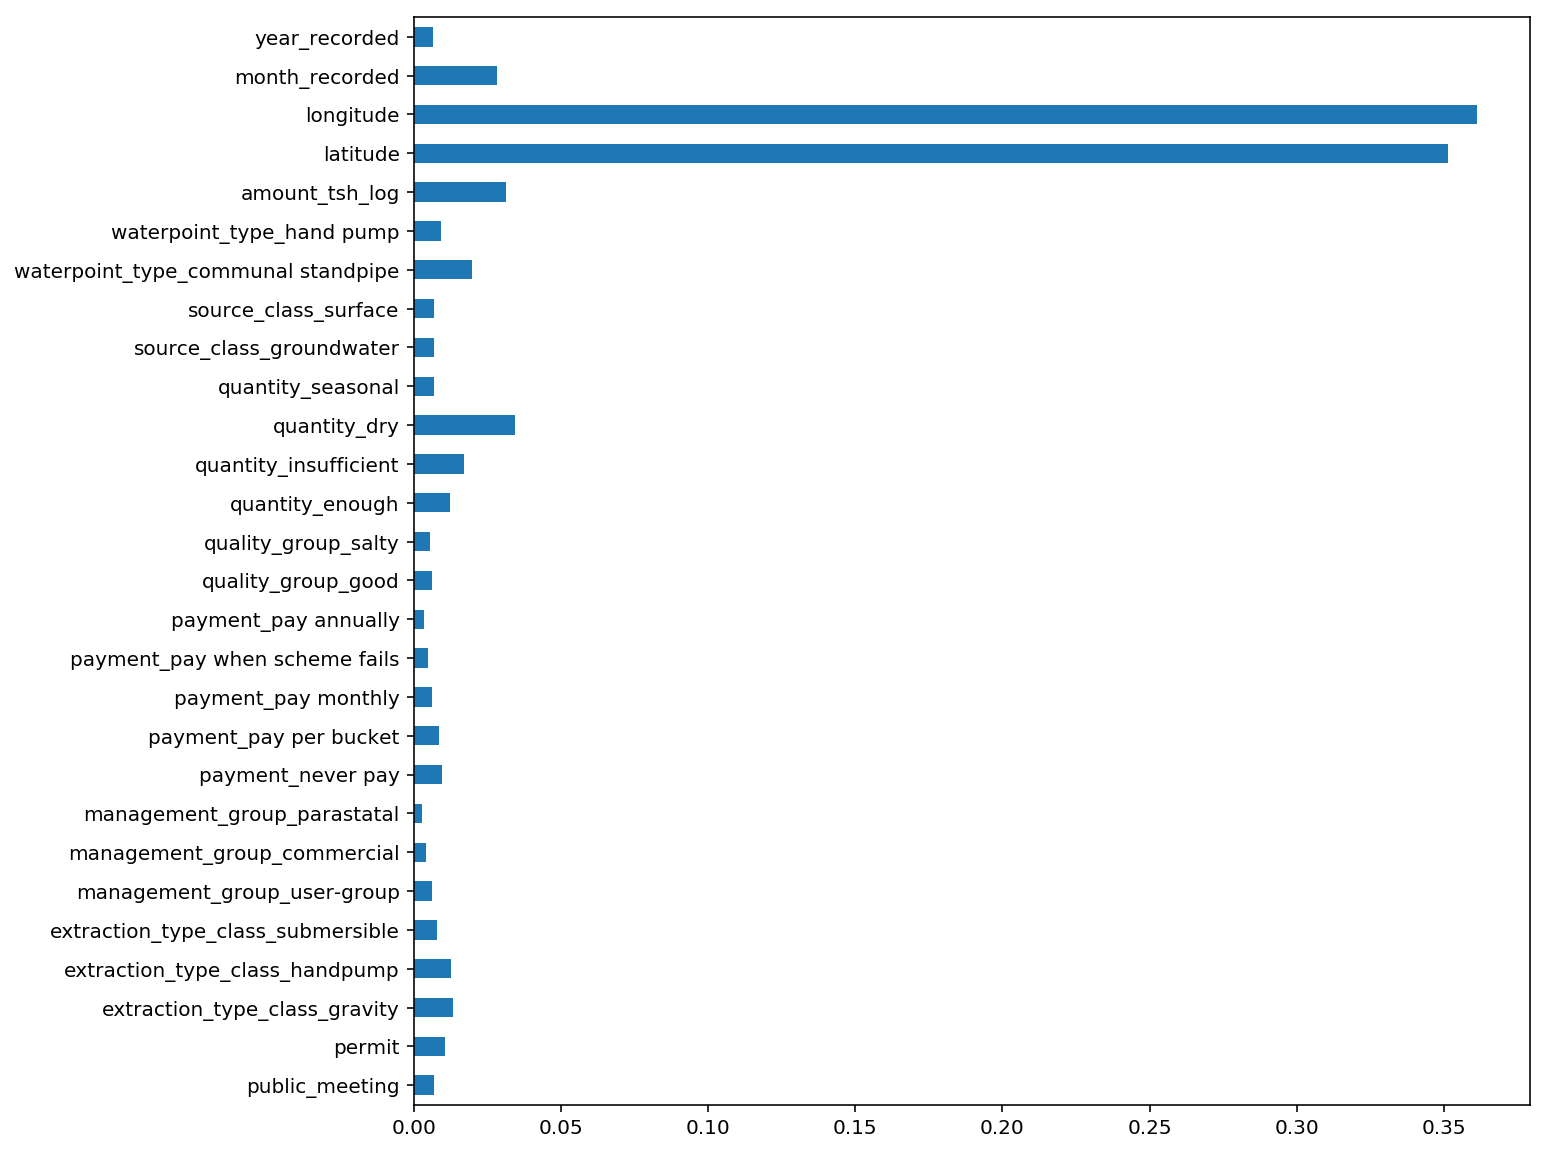

In [51]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(10,10))
pd.DataFrame(clf.feature_importances_,index=X.columns).plot(kind='barh',ax=ax,legend=False)

Location, location, location! It looks like geographical position plays the most important role in the classification of water pump status. This result makes me think that some water pumps are repeat offenders...

## Geographical visualizations

Since location is so important, I wanted to get a chance to visualize. Regions and district boundaries of Tanzania were downloaded from https://energydata.info/dataset/tanzania-region-district-boundary-2012. These boundaries are GeoJSON files, so I'll use ```geopandas``` to analyze. Basically, this package combines the ```shapely``` package for geometry with ```pandas``` in order to do data management seamlessly with identical API and also easily plot shapes and points geographically.

In [89]:
import geopandas as gpd

In [132]:
regions = gpd.read_file('regions.geojson')
regions['Region_Cod'] = pd.to_numeric(regions['Region_Cod'])
districts = gpd.read_file('districts.geojson')
districts.head()
districts['District_C'] = pd.to_numeric(districts['District_C'])

In [197]:
#byreg = pd.merge(features[['region']],labels,on='id',how='inner')
#byreg['frac_func'] = byreg['status_group'].apply(lambda x: 1 if x!='non functional' else 0)
#frac_func = byreg.groupby('region').agg(lambda x: np.sum(x)/len(x)).reset_index()
#frac_func['region'] = frac_func['region'].str.lower()
#regions['Region_Nam'] = regions['Region_Nam'].str.lower()
#regions_func = gpd.GeoDataFrame(pd.merge(frac_func,regions,how='outer',left_on='region',right_on='Region_Nam'))

Here's where I'll create the geometry column for the ```GeoDataFrame``` of each location along with its pump status.

In [271]:
from shapely.geometry import Point
locations = pd.merge(X[['latitude','longitude']],pd.DataFrame(y),on='id')
locations['geometry'] = locations.apply(lambda x: Point(x.longitude,x.latitude),axis=1)
loc_geo = gpd.GeoDataFrame(locations)

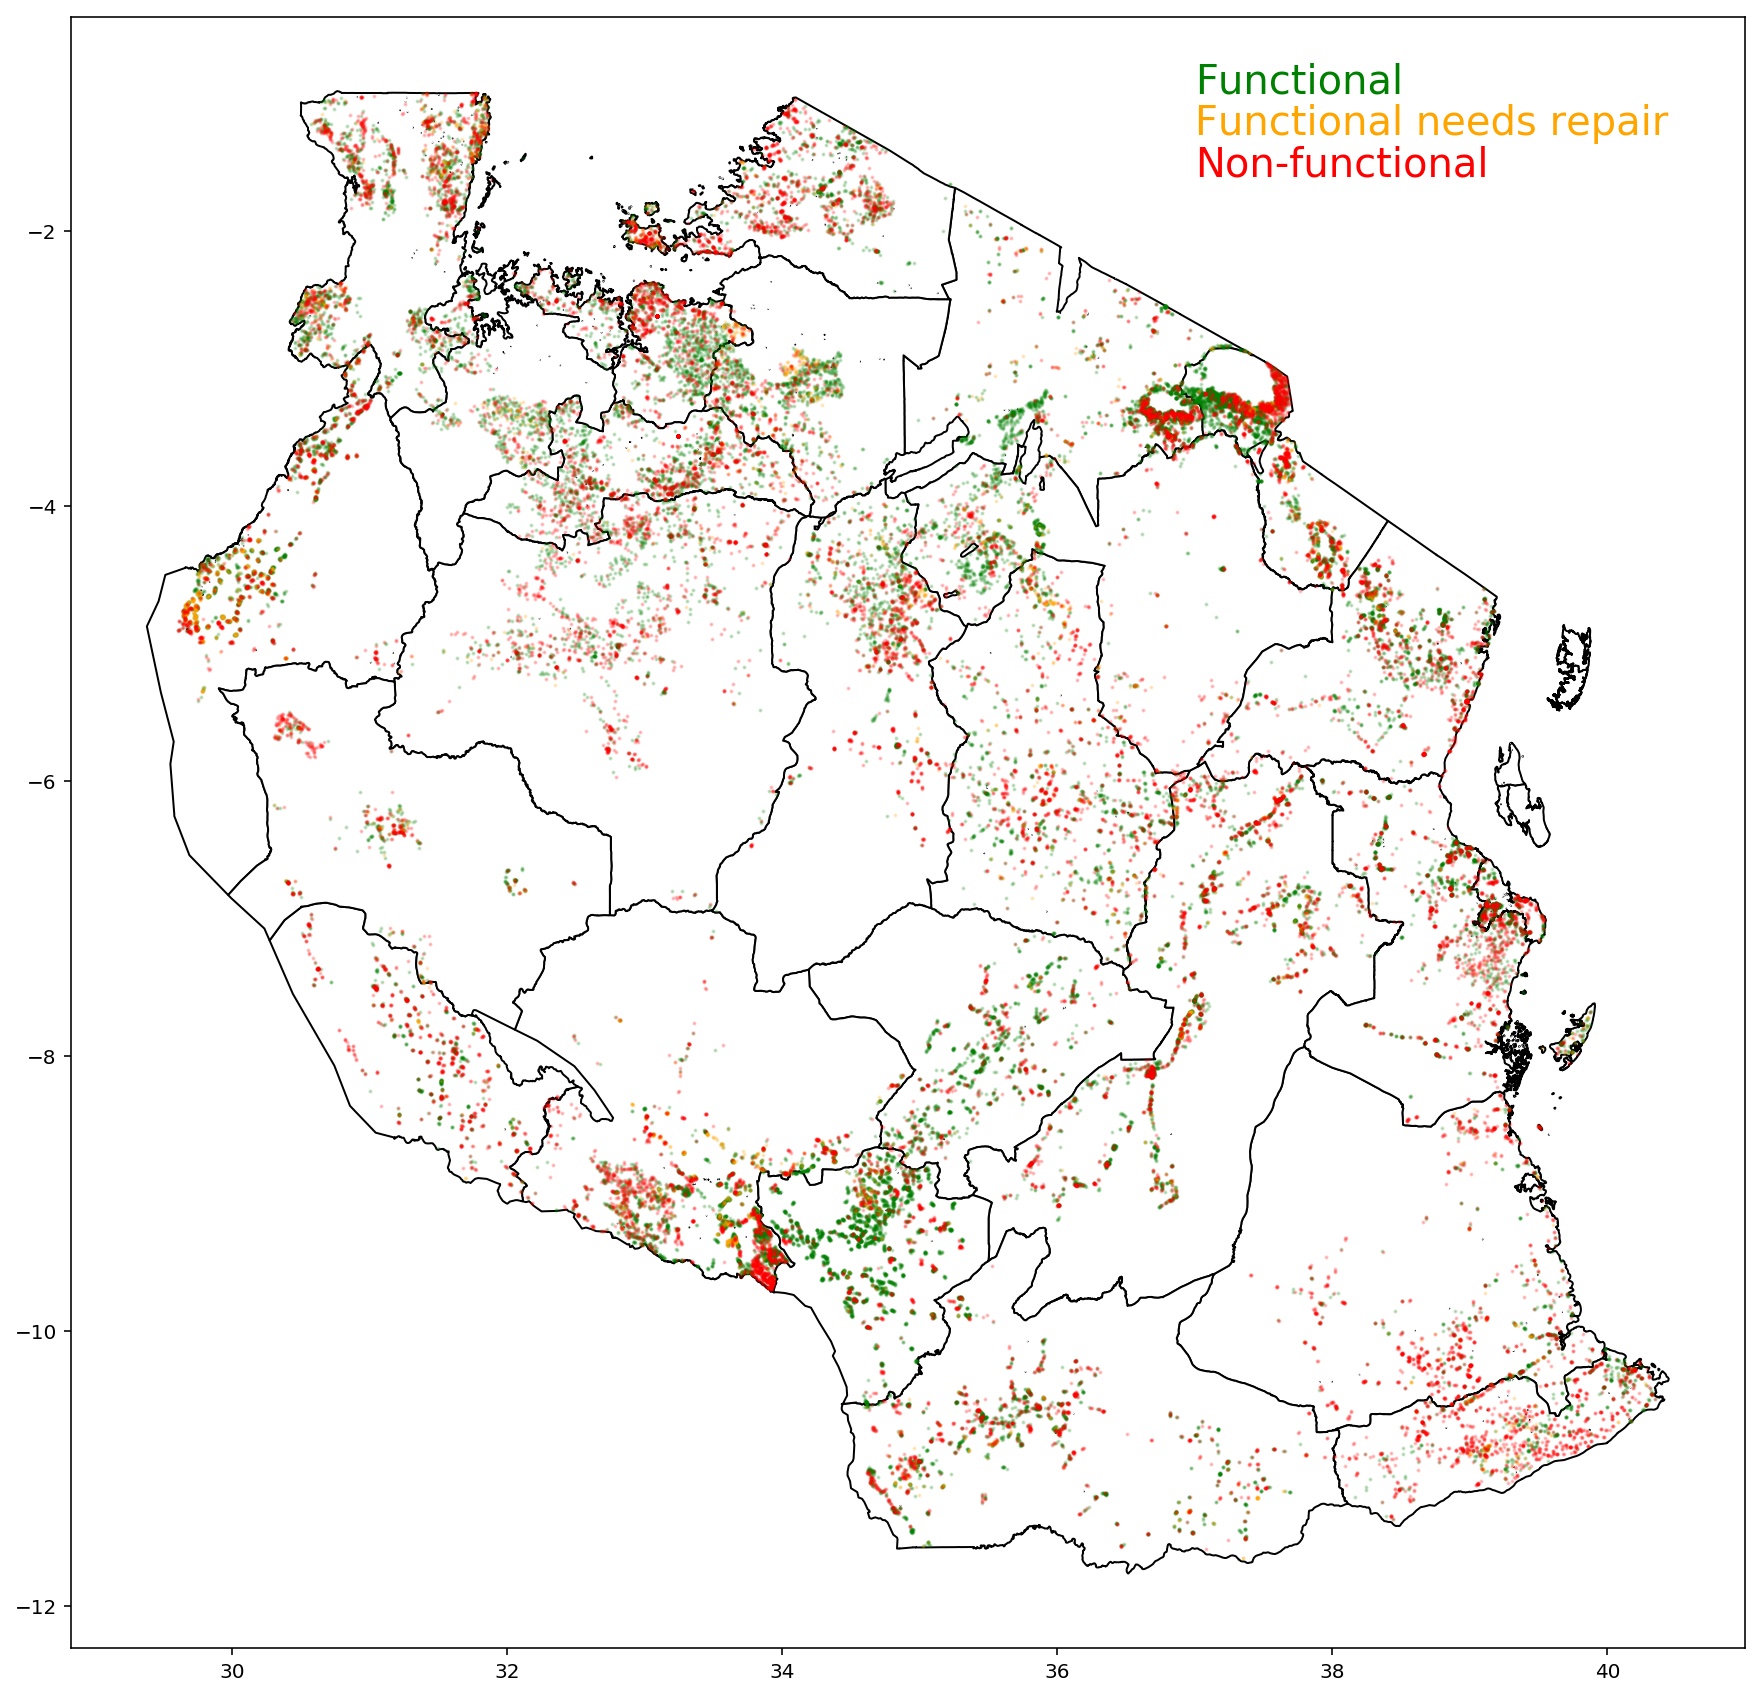

In [288]:
fig,ax = plt.subplots(figsize=(15,15))
regions_func.plot(ax=ax,edgecolor='k',color='white')
loc_geo[loc_geo['status_group'] == 'functional'].plot(ax=ax,color='green',markersize=1,alpha=0.2)
loc_geo[loc_geo['status_group'] == 'functional needs repair'].plot(ax=ax,color='orange',markersize=1,alpha=0.2)
loc_geo[loc_geo['status_group'] == 'non functional'].plot(ax=ax,color='red',markersize=1,alpha=0.2)
ax.text(37,-1.0,"Functional",color='green',size=20)
ax.text(37,-1.3,"Functional needs repair",color='orange',size=20)
ax.text(37,-1.6,"Non-functional",color='red',size=20)
plt.show()

Here you can see where the population centers are and where there are clumps of functioning and broken water pumps. I think its interesting how those clumps can actually be really close to each other. I'm going to have to investigate this some more.

Another strong feature of the data set was the month that the data entry was recorded. Let's look at the breakdown of status by month.

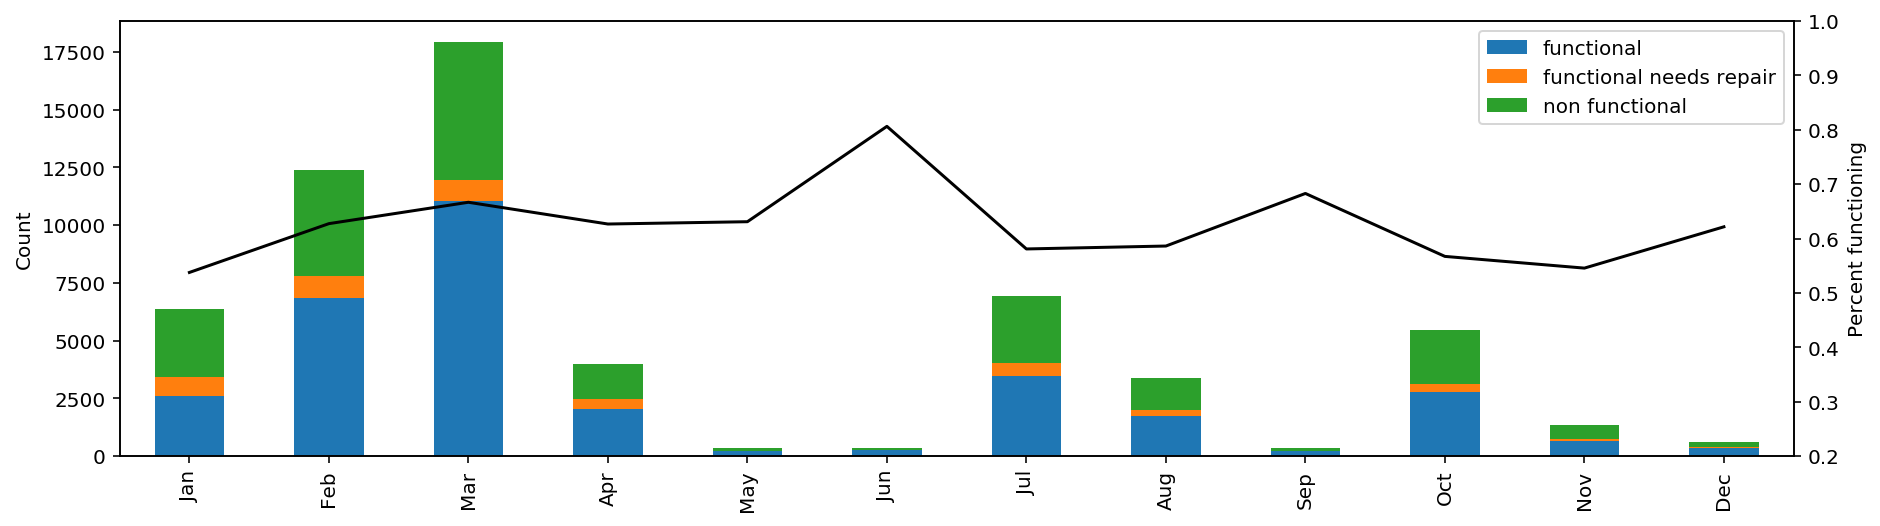

In [316]:
bymonth = pd.merge(X[['month_recorded']],pd.DataFrame(y),on='id')
bymonth_stack = bymonth.groupby(['month_recorded','status_group'])['month_recorded']. \
    count().unstack('status_group')
bymonth_stack['functioning'] = 1-bymonth_stack['non functional']/bymonth_stack.sum(axis=1)
ax = bymonth_stack.plot(kind='bar',stacked=True,figsize=(15,4),legend=False)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax2 = ax.twinx()
handles,labels = ax.get_legend_handles_labels()
ax.legend(handles[:3],labels[:3])
ax2.plot(range(12),bymonth_stack['functioning'],color='k')
ax2.set_ylabel('Percent functioning')
ax2.set_ylim(0.2,1.0)
ax.set_xlabel('')
ax.set_ylabel('Count')
plt.show()

## Import submission data

In [53]:
feat_sub = pd.read_csv('test_values.csv',index_col='id',parse_dates=['date_recorded'])
feat_sub.shape

(14850, 39)

In [290]:
Z = pd.DataFrame(index=feat_sub.index)

#Z = one_hot_encoder(feat_sub,Z,'funder',values=['Government of Tanzania','Danida',
#                                                'Hesawa','Rwssp','World Bank','Kkkt',
#                                               'World_Vision','Unicef'])
Z['public_meeting'] = feat_sub['public_meeting'].apply(lambda x: 1 if x else 0)
#Z = one_hot_encoder(feat_sub,Z,'scheme_management',values=['VWC','WUG','Water authority','WUA','Water Board',
#                                                          'Parastatal','Private operator','Company'])
Z['permit'] = feat_sub['permit'].apply(lambda x: 1 if x else 0)
Z = one_hot_encoder(feat_sub,Z,'extraction_type_class',values=['gravity','handpump','submersible'])
Z = one_hot_encoder(feat_sub,Z,'management_group',values=['user-group','commercial','parastatal'])
Z = one_hot_encoder(feat_sub,Z,'payment',values=['never pay','pay per bucket','pay monthly',
                                                   'pay when scheme fails','pay annually'])
Z = one_hot_encoder(feat_sub,Z,'quality_group',values=['good','salty'])
Z = one_hot_encoder(feat_sub,Z,'quantity',values=['enough','insufficient','dry','seasonal'])
Z = one_hot_encoder(feat_sub,Z,'source_class',values=['groundwater','surface'])
Z = one_hot_encoder(feat_sub,Z,'waterpoint_type',values=['communal standpipe','hand pump'])

Z['amount_tsh_log'] = feat_sub['amount_tsh'].apply(lambda x: np.log(x) if x > 0 else 0)

feat_sub.loc[feat_sub['longitude'] == 0,['latitude','longitude']] = np.nan
Z['latitude'] = feat_sub.groupby('region_code')['latitude'].apply(lambda x: x.fillna(np.mean(x)))
Z['longitude'] = feat_sub.groupby('region_code')['longitude'].apply(lambda x: x.fillna(np.mean(x)))

#ser=pd.cut(feat_sub['construction_year'],[1970,1980,1990,2000,2010,2020])
#counts = ser.value_counts()
#values = counts.index
#for v in values:
#    name = feat_sub.loc[ser==v,'construction_year'].min().astype(str)
#    Z['construction_decade_'+name] = feat_sub['construction_year'].apply(lambda x: 1 if x in v else 0)
Z['month_recorded'] = feat_sub['date_recorded'].apply(lambda x: x.month)
Z['year_recorded'] = feat_sub['date_recorded'].apply(lambda x: x.year)
Z.shape

(14850, 28)

In [291]:
pred = clf.predict(Z)
submission = pd.DataFrame(pred,index=Z.index,columns=labels.columns)
submission.head()

status_group
id                   
50785      functional
51630      functional
17168  non functional
45559  non functional
49871      functional

In [292]:
submission.to_csv('gbc_feat28.csv')

After submitting, my score was 0.7937, which put me at a rank of 1102/5861, which is 81st percentile. The leading score is 0.8285.